In [133]:
import os
from dotenv import load_dotenv
import openai
import csv
import pandas as pd
from openai import OpenAI
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import numpy as np

In [2]:
df = pd.read_csv("IMDB Dataset.csv")

In [5]:
df_small = df.iloc[200:220]

**Sentiment Anaylsis with 1 Prompt**

In [10]:
def get_completion_from_messages(review_text, model="gpt-3.5-turbo", temperature=0):
    messages = [{
        "role": "user",  # Or 'system' as appropriate for your use case
        "content": review_text
    }]
    
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=temperature,
    )
    
    return response.choices[0].message.content

In [17]:
for index, row in df_small.iterrows():
    review = row['review']
    prompt = f"""
    Your task is to determine the sentiment of a review of a movie.

    Determine the Sentiment of the Review below, delimited by triple backticks.

    Give your answer a single word, either "positive" or "negative". Be sure to not use capital letters.

    Review: ```{review}```
    """

    # Assuming get_completion_from_messages is your function to get the sentiment
    response = get_completion_from_messages(prompt)
    # Update the DataFrame with the predicted sentiment
    df_small.at[index, 'predicted_sentiment'] = response.strip()

In [20]:
from sklearn.metrics import classification_report

# Assuming your DataFrame is named df_small
true_labels = df_small['sentiment']
predicted_labels = df_small['predicted_sentiment']

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['negative', 'positive'])

print(report)

              precision    recall  f1-score   support

    negative       0.69      0.90      0.78        10
    positive       0.86      0.60      0.71        10

    accuracy                           0.75        20
   macro avg       0.77      0.75      0.74        20
weighted avg       0.77      0.75      0.74        20



In [21]:
df_small.to_csv('Test.csv', index=False)

**Sentiment Analysis with 2 prompts**

In [27]:
def get_completion_from_messages(prompt, review_text, model="gpt-3.5-turbo", temperature=0):
    # Adjust your function as needed; for simplicity, we assume the prompt includes the review_text
    formatted_prompt = prompt.format(review_text=review_text)
    
    response = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "user",
            "content": formatted_prompt
        }],
        temperature=temperature,
    )
    
    return response.choices[0].message.content

In [28]:
prompt_1 = """
Your task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative". Do not use capital letters.

Review: ```{review_text}```
"""

prompt_2 = """
Given the following movie review, classify its sentiment as "positive" or "negative". Do not use capital letters.

Review: ```{review_text}```
"""

In [29]:
for prompt, column_name in [(prompt_1, 'predicted_sentiment_1'), (prompt_2, 'predicted_sentiment_2')]:
    for index, row in df_small.iterrows():
        review = row['review']
        response = get_completion_from_messages(prompt, review)
        df_small.at[index, column_name] = response.strip()

/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/2251212028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.at[index, column_name] = response.strip()
/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/2251212028.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.at[index, column_name] = response.strip()


In [33]:
# Convert the 'sentiment' column to lowercase
df_small['sentiment'] = df_small['sentiment'].str.lower()

# Convert the predicted sentiment columns to lowercase
df_small['predicted_sentiment_1'] = df_small['predicted_sentiment_1'].str.lower()
df_small['predicted_sentiment_2'] = df_small['predicted_sentiment_2'].str.lower()

/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/595897597.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['sentiment'] = df_small['sentiment'].str.lower()
/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/595897597.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small['predicted_sentiment_1'] = df_small['predicted_sentiment_1'].str.lower()
/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/595897597.py:6: SettingWithCopyWarning: 
A value is t

In [131]:
for column_name in ['predicted_sentiment_1', 'predicted_sentiment_2']:
    print(f"Classification report for {column_name}:")
    predicted_labels = df_small[column_name]
    report = classification_report(true_labels, predicted_labels, target_names=['negative', 'positive'])
    print(report)
    print("\n")

**Automatically generate Prompts**

In [52]:
original_prompt = """
Your task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative". Do not use capital letters.

Review: ```{review_text}```
"""

In [124]:
def generate_prompt_variations(prompt):
   
    messages = [
        {"role": "user", "content": """Generate a good variation of the following instruction for a sentiment analysis task: Your task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative".
        The Variation has to inlcude the following:
         - Output only "positive" or "negative" in a single word 
         - Feel free to change the wording and the lenght of the prompt 
        Every variation has to end with the following: Review: ```{review_text}```
        Make sure to have that exact same ending in every variation.
         Do not ouput anything else but the prompt variation.
         """}
    ]

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=messages,
        temperature=0.8,
        max_tokens=500,  
        n=2,
    )

      # Assuming you want both variations, you'll need to extract both from the response
    variations = [response.choices[i].message.content.strip() for i in range(len(response.choices))]

    return variations

# Generate variations
prompt_variations = generate_prompt_variations(original_prompt)

# Include the original prompt and the generated variations in a list
prompts_with_variations = [original_prompt] + prompt_variations

# Print all prompts to verify
for idx, prompt in enumerate(prompts_with_variations, start=1):
    print(f"Prompt {idx}:\n{prompt}\n{'-'*60}\n")

Prompt 1:

Your task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative". Do not use capital letters.

Review: ```{review_text}```

------------------------------------------------------------

Prompt 2:
Is the movie review positive or negative? State it in one word. Review: ```{review_text}```
------------------------------------------------------------

Prompt 3:
Identify the sentiment as either "positive" or "negative" in the movie review. 
Review: `{review_text}`
------------------------------------------------------------



In [116]:
print(prompts_with_variations)

['\nYour task is to determine the sentiment of a movie review. Give your answer as either "positive" or "negative". Do not use capital letters.\n\nReview: ```{review_text}```\n', 'Please analyze the sentiment of the movie review and provide your response as either "positive" or "negative". Review: ```{review_text}```', 'Determine if the sentiment of the movie review is "positive" or "negative". \nReview: ```{review_text}```']


**Put it all together**

In [120]:
def get_completion_from_messages(prompt_template, review_text, model="gpt-3.5-turbo", temperature=0):
    formatted_prompt = prompt_template.format(review_text=review_text)
    
    # Assuming 'client' is already defined and authorized to use OpenAI's API
    response = client.chat.completions.create(
        model=model,
        messages=[{
            "role": "user",
            "content": formatted_prompt
        }],
        temperature=temperature,
    )
    
    return response.choices[0].message.content.strip().lower()

In [125]:
for idx, prompt_template in enumerate(prompts_with_variations, start=1):
    column_name = f'predicted_sentiment_{idx}'
    
    for index, row in df_small.iterrows():
        review = row['review']
        response = get_completion_from_messages(prompt_template, review)
        df_small.at[index, column_name] = response.strip().lower()


In [126]:
df_small.head()

,review,sentiment,predicted_sentiment,predicted_sentiment_1,predicted_sentiment_2,predicted_sentiment_3
200,Interesting and short television movie describ...,negative,positive,positive,positive,positive
201,Any film about WWII made during WWII by a Brit...,positive,positive,positive,positive,positive
202,A brilliant horror film. Utterly gruesome and ...,positive,positive,positive,positive,positive
203,I absolutely love this film. Everything about ...,positive,positive,positive,positive,positive
204,No one can say I wasn't warned as I have read ...,negative,negative,negative,negative,negative


In [129]:
# Assuming you have a DataFrame df and you want to drop the column 'unwanted_column'
df_small.drop(columns=['predicted_sentiment'], inplace=True)


/var/folders/xg/jz066c5d5jn87vqnb688_0d00000gn/T/ipykernel_44568/2808367797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_small.drop(columns=['predicted_sentiment'], inplace=True)


In [132]:
# After running the predictions, you may want to compare the results
for idx in range(1, len(prompts_with_variations) + 1):
    column_name = f'predicted_sentiment_{idx}'
    predicted_labels = df_small[column_name]
    
    # Generate classification report as a dictionary
    report_dict = classification_report(true_labels, predicted_labels, target_names=['negative', 'positive'], output_dict=True)
    
    # Extract the F1 scores
    f1_score_negative = report_dict['negative']['f1-score']
    f1_score_positive = report_dict['positive']['f1-score']
    f1_score_average = report_dict['macro avg']['f1-score']  # or 'weighted avg' for weighted average
    
    # Store the scores in the f1_scores dictionary
    f1_scores[column_name] = {
        'negative': f1_score_negative,
        'positive': f1_score_positive,
        'average': f1_score_average
    }

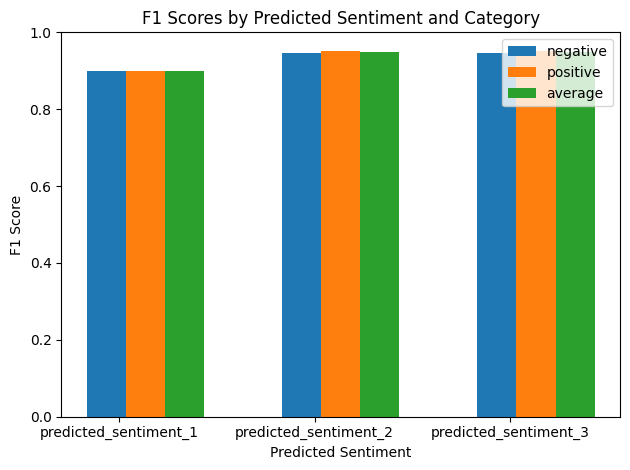

In [134]:
import matplotlib.pyplot as plt
import numpy as np

# Setup for plotting
categories = ['negative', 'positive', 'average']
n_categories = len(categories)
n_predictions = len(f1_scores)

# Create a figure and a set of subplots
fig, ax = plt.subplots()

# Index for each of the bars
index = np.arange(n_predictions)
bar_width = 0.2

# Plotting each category
for i, category in enumerate(categories):
    scores = [f1_scores[prediction][category] for prediction in f1_scores]
    ax.bar(index + i * bar_width, scores, bar_width, label=category)

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Predicted Sentiment')
ax.set_ylabel('F1 Score')
ax.set_title('F1 Scores by Predicted Sentiment and Category')
ax.set_xticks(index + bar_width / n_categories)
ax.set_xticklabels(list(f1_scores.keys()))
ax.legend()

# Make layout more compact
plt.tight_layout()

# Show plot
plt.show()
